# MNIST Clustering

## 1. Whole-Image Clustering with K-Means

The code below loads the data and clusters the images into 10 clusters.

We then visualize the centroids as images. Do they correspond to the digits? Remember that K-Means has *no* knowledge of the labels. 

In [1]:
# setup:
import numpy as np
import urllib2
import matplotlib.pyplot as plt
%matplotlib inline

def load(url):
    """read a CSV from the web, return data and labels"""
    response = urllib2.urlopen(url)
    Xy = np.loadtxt(response, delimiter=',')
    y = Xy[:, -1]
    X = Xy[:, :-1]
    return X, y

digitX, digity = load('http://cs.wellesley.edu/~sravana/ml/ps1/data/mnist1100/training.txt')
print 'Loaded training data', digitX.shape

Loaded training data (10000, 784)


In [2]:
from sklearn.cluster import KMeans

model10 = KMeans(n_clusters=10)
model10.fit(digitX)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)


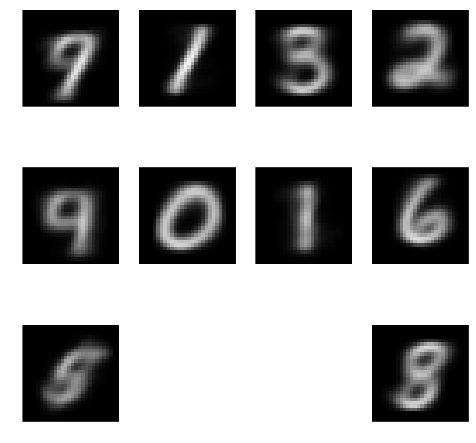

In [3]:
def visualize_centroids(centroids):
    fig = plt.figure(figsize=(8, 8))
    
    # display grid shape
    numrows = int(np.sqrt(len(centroids)))
    numcols = int(len(centroids)/numrows)+1
    
    for i in range(len(centroids)):
        c = centroids[i]
        ax = fig.add_subplot(numrows,numcols,i)    
        ax.axis('off')
        ax.imshow(c.reshape(28, 28), 
                  interpolation='none', cmap = plt.get_cmap('gray'), vmin = 0, vmax = 255)
    plt.show()
    
visualize_centroids(model10.cluster_centers_)

What happens with a larger number of clusters?

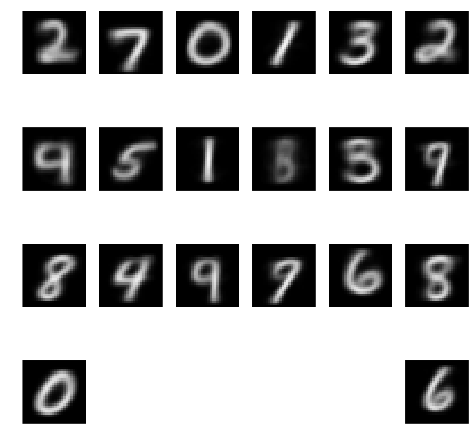

In [4]:
model20 = KMeans(n_clusters=20)
model20.fit(digitX)
visualize_centroids(model20.cluster_centers_)

### Extrinsic Evaluation

Evaluate the clustering result against the true labels. 
Build a confusion matrix where the rows are the true labels and the columns are the clusters.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


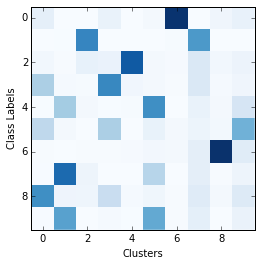

Purity of 10-means result 0.5722


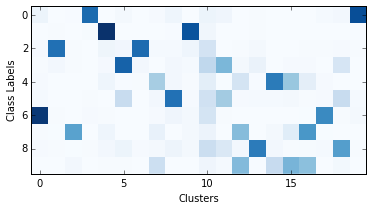

Purity of 20-means result 0.6957


In [5]:
def evaluate(y_true, y_clusters):
    cm = np.zeros((np.max(y_true)+1, np.max(y_clusters)+1))
    for i in range(y_true.size):
        cm[y_true[i], y_clusters[i]]+=1
    plt.imshow(cm, interpolation='none', cmap=plt.cm.Blues)
    plt.ylabel('Class Labels')
    plt.xlabel('Clusters')
    plt.show()
    purity = 0.
    for cluster in range(cm.shape[1]):  # clusters are along columns
        purity += np.max(cm[:, cluster])
    return purity/y_true.size

    
purity = evaluate(digity, model10.labels_)
print 'Purity of 10-means result', purity

purity = evaluate(digity, model20.labels_)
print 'Purity of 20-means result', purity



## 2. Patch Vocabulary Extraction

So far, you have featurized images by treating each pixel location as a feature, and the pixel intensity as the corresponding values.

**Disadvantages of this approach**: 
- Assumes that all images are of the same size
- Does not model larger regions of the image. 

Instead, drawing inspiration from bag-of-words representations of text, let each feature be a "visual word": e.g. a 6x6 patch, and each value be the count of that patch in the image.

**Problem**: How many possible patches are there?

**Solution**: Reduce this combinatorial explosion by clustering all patches into a small-ish "vocabulary". Each cluster contains visually similar patches. 

396000 patches extracted


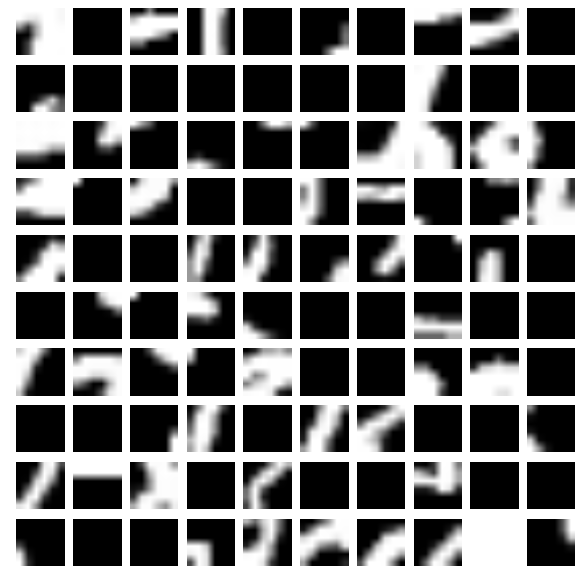

In [9]:
from sklearn.feature_extraction.image import extract_patches_2d

patch_size = (6, 6)
all_patches = []
for i in range(0, len(digitX), 10):  # only get every 10th example to save space
    this_image = digitX[i, :]
    # center and scale
    this_image -= np.mean(this_image)
    this_image /= np.std(this_image)
    this_image = this_image.reshape((28, 28))
    patch = extract_patches_2d(this_image, patch_size, max_patches=0.75)
    all_patches.extend(patch.reshape((len(patch)), -1))
    
all_patches = np.array(all_patches) 

print len(all_patches), 'patches extracted'

# visualize a random set of patches
fig = plt.figure(figsize=(10, 10))
ctr = 0
for i in range(0, len(all_patches), 4000):
    ax=fig.add_subplot(10,10,ctr)    
    ax.axis('off')
    ax.imshow(all_patches[i].reshape(patch_size), cmap='gray')
    ctr+=1
plt.show()

### Patch Clustering

Now we cluster the above patches using k-means.

In [ ]:
from sklearn.cluster import KMeans 
model = KMeans(n_clusters=50, n_init=3, max_iter=300)
model.fit(all_patches)

Visualizing each centroid...

In [ ]:
fig = plt.figure(figsize=(10, 10))
for i in range(len(model.cluster_centers_)):
    plt.subplot(10,10,i)    
    plt.axis('off')
    plt.imshow(model.cluster_centers_[i].reshape(patch_size), cmap='gray')

plt.tight_layout()
plt.show()

### Featurizing Digits as Bag-of-Patches

To featurize digit images in terms of this "vocabulary" of k clusters:

1. Extract all the patches in the image
2. Represent each patch by its cluster ID 
3. Count the number of patches assigned to each cluster ID in the image
4. Return a vector of size k with the counts

In [ ]:
from scipy.spatial.distance import cdist

def bagofpatches(X, centroids):
    """featurize each digit in X as described"""
    # num rows = num points, num columns (features) = number of clusters 
    numpoints = X.shape[0]
    numfeats = centroids.shape[0]
    featurized = np.zeros((numpoints, numfeats))  
    for i in range(numpoints):
        this_image = digitX[i, :]
        # center and scale
        this_image -= np.mean(this_image)
        this_image /= np.std(this_image)
        this_image = this_image.reshape((28, 28))
        patches = extract_patches_2d(this_image, patch_size)
        patches = np.reshape(patches, (len(patches), patch_size[0]*patch_size[1]))
        # compute distance to each centroid
        centroid_distances = cdist(patches, centroids)
        nearest = np.argsort(centroid_distances, axis=1)[:, 0]
        # get counts of each centroid 
        featurized[i, :] = np.bincount(nearest, minlength=numfeats)
    return featurized